In [3]:
import numpy as np
import pickle as pkl
import re
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from pyspark.mllib.clustering import KMeans
from collections import Counter
from nltk.corpus import stopwords
import string
import pyspark as ps    # for the pyspark suite
from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, StringType
import unicodedata
import nltk

from nltk.tokenize import sent_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.util import ngrams
from nltk import pos_tag
from nltk import RegexpParser

from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import IDF

import sys
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, RegexTokenizer, StopWordsRemover, NGram, \
        CountVectorizer, IDF, Word2Vec
from pyspark.sql.functions import udf, col, explode, collect_list, to_date, concat
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, \
        FloatType, ArrayType, BooleanType
from nltk.stem import SnowballStemmer





In [4]:
df_full = spark.read.csv('s3a://usfocus/congress_full.csv',header = True,inferSchema=True,sep=",")


In [5]:
df_full.printSchema()

root
 |-- content: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- dates: string (nullable = true)
 |-- name: string (nullable = true)
 |-- congress: double (nullable = true)



In [6]:
df_full.count()

81124

In [7]:
tokenizer = RegexTokenizer(inputCol="content", outputCol="tokens", pattern="\\W", minTokenLength=3)

remover = StopWordsRemover(inputCol="tokens", outputCol='tokens_nostopwords')

from pyspark import keyword_only
from pyspark.ml.util import Identifiable
from pyspark.ml.pipeline import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param
from nltk.stem import SnowballStemmer
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

# Custom stemming transformer class for pyspark
class Stemming_Transformer(Transformer, HasInputCol, HasOutputCol):
    @keyword_only
    def __init__(self, inputCol=None, outputCol=None):
        super(Stemming_Transformer, self).__init__()
        kwargs = self.__init__._input_kwargs
        self.setParams(**kwargs)

    @keyword_only
    def setParams(self, inputCol=None, outputCol=None, language='english', ):
        kwargs = self.setParams._input_kwargs
        return self._set(**kwargs)

    def _transform(self, dataset):
        opinion_stemm = SnowballStemmer('english')
        udfStemmer = udf(lambda tokens: [opinion_stemm.stem(word) for word in tokens], ArrayType(StringType()))

        inCol = self.getInputCol()
        outCol = self.getOutputCol()

        return dataset.withColumn(outCol, udfStemmer(inCol))

stemmer = Stemming_Transformer(inputCol='tokens_nostopwords', outputCol='tokens_stemmed')

cv = CountVectorizer(inputCol='tokens_stemmed', outputCol='tokens_countvectorized', minDF=2.0,vocabSize=5000)

idf = IDF(inputCol='tokens_countvectorized', outputCol='token_idf')

In [8]:
#w2v_2d = Word2Vec(vectorSize=2, minCount=2, inputCol=stemmer.getOutputCol(), outputCol='word2vec_2d')



#w2v_large = Word2Vec(vectorSize=250, minCount=2, inputCol=stemmer.getOutputCol(), outputCol='word2vec_large')


pipe_stem = Pipeline(stages=[tokenizer, remover, stemmer])

model_stem = pipe_stem.fit(df_full)

df_stemmed = model_stem.transform(df_full)


In [9]:
cv_model = cv.fit(df_stemmed)

df_countvector = cv_model.transform(df_stemmed)

Vocab = cv_model.vocabulary

In [10]:
len(Vocab)

5000

In [11]:
model_idf = idf.fit(df_countvector)

df_tfidf = model_idf.transform(df_countvector)

In [12]:

sub_list =['Health',
 'Government+Operations+and+Politics',
 'Taxation',
 'Armed+Forces+and+National+Security',
 'Public+Lands+and+Natural+Resources',
 'International+Affairs',
 'Congress',
 'Crime+and+Law+Enforcement',
 'Immigration',
 'Science,+Technology,+Communications',
 'Education',
 'Finance+and+Financial+Sector',
 'Environmental+Protection',
 'Labor+and+Employment',
 'Transportation+and+Public+Works',
 'Energy',
 'Civil+Rights+and+Liberties,+Minority+Issues',
 'Emergency+Management',
 'Law',
 'Economics+and+Public+Finance',
 'Commerce',
 'Native+Americans',
 'Housing+and+Community+Development',
 'Social+Welfare',
 'Water+Resources+Development',
 'Agriculture+and+Food',
 'Animals',
 'Foreign+Trade+and+International+Finance',
 'Families',
 'Sports+and+Recreation',
 'Arts,+Culture,+Religion',
 'Social+Sciences+and+History']

sub_dict = {}
for i in range(len(sub_list)):
    sub_dict[sub_list[i]] = i

sub_dict



{'Agriculture+and+Food': 25,
 'Animals': 26,
 'Armed+Forces+and+National+Security': 3,
 'Arts,+Culture,+Religion': 30,
 'Civil+Rights+and+Liberties,+Minority+Issues': 16,
 'Commerce': 20,
 'Congress': 6,
 'Crime+and+Law+Enforcement': 7,
 'Economics+and+Public+Finance': 19,
 'Education': 10,
 'Emergency+Management': 17,
 'Energy': 15,
 'Environmental+Protection': 12,
 'Families': 28,
 'Finance+and+Financial+Sector': 11,
 'Foreign+Trade+and+International+Finance': 27,
 'Government+Operations+and+Politics': 1,
 'Health': 0,
 'Housing+and+Community+Development': 22,
 'Immigration': 8,
 'International+Affairs': 5,
 'Labor+and+Employment': 13,
 'Law': 18,
 'Native+Americans': 21,
 'Public+Lands+and+Natural+Resources': 4,
 'Science,+Technology,+Communications': 9,
 'Social+Sciences+and+History': 31,
 'Social+Welfare': 23,
 'Sports+and+Recreation': 29,
 'Taxation': 2,
 'Transportation+and+Public+Works': 14,
 'Water+Resources+Development': 24}

In [13]:
df_presidential = spark.read.json('s3a://usfocus/presidential-full-final.json')

In [14]:
df_presidential.count()

975

In [15]:
df_presidential = df_presidential.filter(df_presidential['content'] != 'null')

In [16]:
df_presidential.count()

974

In [17]:
df_presidential.show()

+---------------+--------------------+--------------------+------------------+--------------------+--------------------+
|_corrupt_record|                 _id|             content|              date|                link|        speech_title|
+---------------+--------------------+--------------------+------------------+--------------------+--------------------+
|           null|[58d03d7addc55a11...|Thank you.  (Appl...|    March 22, 2016|https://millercen...| Remarks to the P...|
|           null|[58d03d7fddc55a11...|Mr. Speaker, Mr. ...|  January 12, 2016|https://millercen...| 2016 State of th...|
|           null|[58d03d84ddc55a11...|THE PRESIDENT:  G...|     June 26, 2015|https://millercen...| Remarks in Eulog...|
|           null|[58d03d89ddc55a11...|UDIENCE MEMBER:  ...|     March 7, 2015|https://millercen...| Remarks at the 5...|
|           null|[58d03d8eddc55a11...|Mr. Speaker, Mr. ...|  January 20, 2015|https://millercen...| 2015 State of th...|
|           null|[58d03d93ddc55a

In [18]:
model_stem_pre = pipe_stem.fit(df_presidential)

In [19]:
df_pres_stem = model_stem_pre.transform(df_presidential)

In [20]:
df_pres_stem.show()

+---------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|_corrupt_record|                 _id|             content|              date|                link|        speech_title|              tokens|  tokens_nostopwords|      tokens_stemmed|
+---------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|           null|[58d03d7addc55a11...|Thank you.  (Appl...|    March 22, 2016|https://millercen...| Remarks to the P...|[thank, you, appl...|[thank, applause,...|[thank, applaus, ...|
|           null|[58d03d7fddc55a11...|Mr. Speaker, Mr. ...|  January 12, 2016|https://millercen...| 2016 State of th...|[speaker, vice, p...|[speaker, vice, p...|[speaker, vice, p...|
|           null|[58d03d84ddc55a11...|THE PRESIDENT:  G...|     June 26, 2015|ht

In [21]:
Vector_presidential = cv_model.transform(df_pres_stem)

In [22]:
Vector_presidential.printSchema()

root
 |-- _corrupt_record: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- $oid: string (nullable = true)
 |-- content: string (nullable = true)
 |-- date: string (nullable = true)
 |-- link: string (nullable = true)
 |-- speech_title: string (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_nostopwords: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_stemmed: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_countvectorized: vector (nullable = true)



In [23]:
Vector_presidential.show()

+---------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------+
|_corrupt_record|                 _id|             content|              date|                link|        speech_title|              tokens|  tokens_nostopwords|      tokens_stemmed|tokens_countvectorized|
+---------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------+
|           null|[58d03d7addc55a11...|Thank you.  (Appl...|    March 22, 2016|https://millercen...| Remarks to the P...|[thank, you, appl...|[thank, applause,...|[thank, applaus, ...|  (5000,[2,8,10,11,...|
|           null|[58d03d7fddc55a11...|Mr. Speaker, Mr. ...|  January 12, 2016|https://millercen...| 2016 State of th...|[speaker, vice, p...|[speaker, vice, p...|[speaker, 

In [24]:
df_tfidf_pre = model_idf.transform(Vector_presidential)

In [25]:
df_tfidf_pre.show()

+---------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------+--------------------+
|_corrupt_record|                 _id|             content|              date|                link|        speech_title|              tokens|  tokens_nostopwords|      tokens_stemmed|tokens_countvectorized|           token_idf|
+---------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------+--------------------+
|           null|[58d03d7addc55a11...|Thank you.  (Appl...|    March 22, 2016|https://millercen...| Remarks to the P...|[thank, you, appl...|[thank, applause,...|[thank, applaus, ...|  (5000,[2,8,10,11,...|(5000,[2,8,10,11,...|
|           null|[58d03d7fddc55a11...|Mr. Speaker, Mr. ...|  January 12, 2016|https://mi

In [26]:
topicWord=udf(lambda tkn: sub_dict[tkn],IntegerType())

In [27]:
df_tfidf=df_tfidf.withColumn("label",topicWord(df_tfidf.subject))

In [28]:
df_tfidf.printSchema()

root
 |-- content: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- dates: string (nullable = true)
 |-- name: string (nullable = true)
 |-- congress: double (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_nostopwords: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_stemmed: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_countvectorized: vector (nullable = true)
 |-- token_idf: vector (nullable = true)
 |-- label: integer (nullable = true)



In [90]:
df_tfidf.write.json('s3a://usfocus/congress_tfidf_2nd.json')

In [29]:
from pyspark.ml.classification import NaiveBayes

In [30]:
nb = NaiveBayes(smoothing=1.0, modelType="multinomial",featuresCol="token_idf", labelCol="label")

In [31]:
splits = df_tfidf.randomSplit([0.7, 0.3])

In [32]:
df_train = splits[0]
df_test = splits[1]

In [ ]:
#df_train.count(), df_test.count(), df_transformed.count()

In [46]:
df_train.persist()

DataFrame[content: string, subject: string, dates: string, name: string, congress: double, tokens: array<string>, tokens_nostopwords: array<string>, tokens_stemmed: array<string>, tokens_countvectorized: vector, token_idf: vector, label: int]

In [47]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [48]:
model = nb.fit(df_train)

# apply the model on the test setM
result = model.transform(df_test)

# keep only label and prediction to compute accuracy
predictionAndLabels = result.select("prediction", "label")

# compute accuracy on the test set
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                                  metricName="accuracy")

print("Accuracy: {}".format(evaluator.evaluate(predictionAndLabels)))

Accuracy: 0.755299991815


In [49]:
thetaarray = model.theta.toArray().T

In [50]:
import numpy as np

In [51]:
thetaarray.shape

(5000, 32)

In [52]:
thetaarray[0]

array([-6.44590418, -6.43343054, -5.85717183, -6.52351288, -7.02232651,
       -7.08194578, -6.85005214, -6.53172559, -6.29349743, -6.92021564,
       -6.64341211, -6.49222054, -6.73765527, -6.28748885, -6.48646872,
       -6.71948854, -6.67430144, -6.7454701 , -6.58944382, -6.53970928,
       -6.59213549, -6.85835928, -6.28178018, -6.25293172, -7.0096497 ,
       -6.66029902, -6.72710336, -6.72332243, -6.44808934, -7.16209552,
       -7.06001318, -8.58070375])

In [53]:
from sklearn.metrics import confusion_matrix

In [54]:
result.printSchema()

root
 |-- content: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- dates: string (nullable = true)
 |-- name: string (nullable = true)
 |-- congress: double (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_nostopwords: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_stemmed: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_countvectorized: vector (nullable = true)
 |-- token_idf: vector (nullable = true)
 |-- label: integer (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = true)



In [55]:
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=6)
    plt.yticks(tick_marks, classes,fontsize=6)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    #for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    #    plt.text(j, i, cm[i, j],
    #             horizontalalignment="center",
    #             color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.figure(figsize=(20,20))


In [56]:
true_label = result.select('label').collect()

predict_label = result.select('prediction').collect()

In [57]:
len(true_label),len(predict_label)

(24434, 24434)

In [58]:
confusion_matrix_nb = confusion_matrix(np.array(true_label), np.array(predict_label))

In [59]:
confusion_matrix_nb

array([[1594,   15,   12, ...,    3,    2,   35],
       [  24,  889,    9, ...,    5,   46,   86],
       [  45,   23, 1910, ...,    5,    1,    5],
       ..., 
       [   0,    0,    0, ...,   49,    2,    6],
       [   0,    0,    0, ...,    0,   60,   30],
       [   1,    0,    0, ...,    0,    1,   24]])

In [60]:
subject_ordered = sorted(sub_dict,key=sub_dict.get)

In [61]:
label_list=range(0,32)

Confusion matrix, without normalization
[[1594   15   12 ...,    3    2   35]
 [  24  889    9 ...,    5   46   86]
 [  45   23 1910 ...,    5    1    5]
 ..., 
 [   0    0    0 ...,   49    2    6]
 [   0    0    0 ...,    0   60   30]
 [   1    0    0 ...,    0    1   24]]


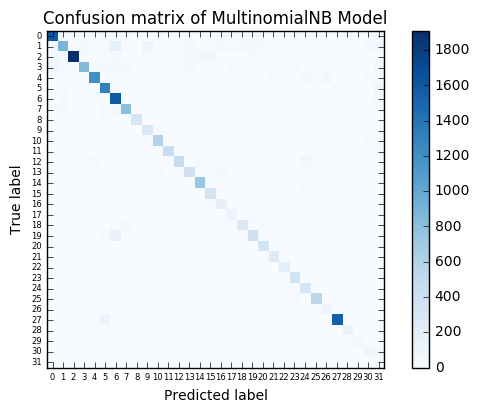

In [62]:
plot_confusion_matrix(confusion_matrix_nb, classes = label_list,normalize = False, title = 'Confusion matrix of MultinomialNB Model')

In [ ]:
#df_tfidf.write.json('s3a://usfocus/congress_tfidf.json')

In [ ]:
#result.write.json('s3a://usfocus/result_tfidf.csv')

In [63]:
result_presidential = model.transform(df_tfidf_pre)

In [64]:
result_presidential = result_presidential.select('content','date','link','speech_title','tokens_countvectorized','tokens_stemmed','token_idf','rawPrediction','probability','prediction')

In [65]:
result_presidential.printSchema()

root
 |-- content: string (nullable = true)
 |-- date: string (nullable = true)
 |-- link: string (nullable = true)
 |-- speech_title: string (nullable = true)
 |-- tokens_countvectorized: vector (nullable = true)
 |-- tokens_stemmed: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- token_idf: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = true)



In [66]:
result_presidential.write.json('s3a://usfocus/result_presidential_tfidf.json')

In [67]:
from pyspark.ml.classification import LogisticRegression

In [68]:
LG = LogisticRegression(featuresCol="token_idf", labelCol="label")

In [69]:
model_lg = LG.fit(df_train)

# apply the model on the test setM
result_lg = model_lg.transform(df_test)

In [70]:
result_lg.printSchema()

root
 |-- content: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- dates: string (nullable = true)
 |-- name: string (nullable = true)
 |-- congress: double (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_nostopwords: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_stemmed: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_countvectorized: vector (nullable = true)
 |-- token_idf: vector (nullable = true)
 |-- label: integer (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = true)



In [71]:
# keep only label and prediction to compute accuracy
predictionAndLabels_lg = result_lg.select("prediction", "label")

# compute accuracy on the test set
evaluator_lg = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                                  metricName="accuracy")

print("Accuracy: {}".format(evaluator_lg.evaluate(predictionAndLabels_lg)))

Accuracy: 0.851190963412


In [72]:
predict_label_lg = result_lg.select('prediction').collect()

In [73]:
len(true_label),len(predict_label_lg)

(24434, 24434)

In [74]:
confusion_matrix_lg = confusion_matrix(np.array(true_label), np.array(predict_label_lg))

In [75]:
confusion_matrix_lg

array([[1794,   17,   18, ...,    2,    0,    0],
       [  12, 1422,    8, ...,    0,   10,    1],
       [  16,   12, 2214, ...,    0,    2,    0],
       ..., 
       [   0,    2,    1, ...,   48,    0,    1],
       [   0,   10,    0, ...,    1,   65,    5],
       [   0,    2,    0, ...,    0,    2,    9]])

Confusion matrix, without normalization
[[1794   17   18 ...,    2    0    0]
 [  12 1422    8 ...,    0   10    1]
 [  16   12 2214 ...,    0    2    0]
 ..., 
 [   0    2    1 ...,   48    0    1]
 [   0   10    0 ...,    1   65    5]
 [   0    2    0 ...,    0    2    9]]


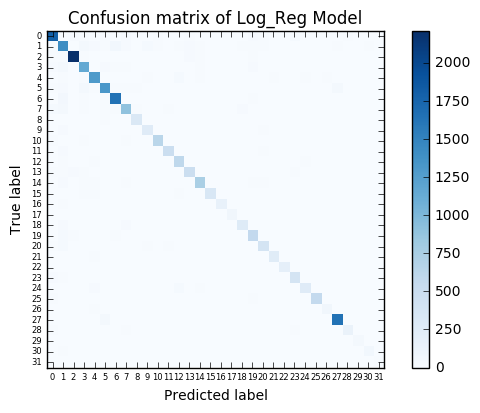

In [76]:
plot_confusion_matrix(confusion_matrix_lg, classes = label_list,normalize = False, title = 'Confusion matrix of Log_Reg Model')

In [77]:
from pyspark.ml.classification import RandomForestClassifier

In [78]:
rf = RandomForestClassifier(featuresCol="token_idf", labelCol="label")

In [79]:
model_rf = rf.fit(df_train)

# apply the model on the test setM
result_rf = model_rf.transform(df_test)

In [82]:
result_rf.printSchema()

root
 |-- content: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- dates: string (nullable = true)
 |-- name: string (nullable = true)
 |-- congress: double (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_nostopwords: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_stemmed: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_countvectorized: vector (nullable = true)
 |-- token_idf: vector (nullable = true)
 |-- label: integer (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = true)



In [80]:
# keep only label and prediction to compute accuracy
predictionAndLabels_rf = result_rf.select("prediction", "label")

# compute accuracy on the test set
evaluator_rf = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                                  metricName="accuracy")

print("Accuracy: {}".format(evaluator_rf.evaluate(predictionAndLabels_rf)))

Accuracy: 0.457600065483


In [81]:
predict_label_rf = result_rf.select('prediction').collect()

In [83]:


len(true_label),len(predict_label_rf)

(24434, 24434)

In [84]:
confusion_matrix_rf = confusion_matrix(np.array(true_label), np.array(predict_label_rf))

In [85]:
confusion_matrix_rf

array([[1758,   40,   68, ...,    0,    0,    0],
       [ 145,  757,  474, ...,    0,    0,    0],
       [  20,   25, 2266, ...,    0,    0,    0],
       ..., 
       [  12,   12,   12, ...,    0,    0,    0],
       [   5,   17,   12, ...,    0,    0,    0],
       [   0,    3,    1, ...,    0,    0,    0]])

Confusion matrix, without normalization
[[1758   40   68 ...,    0    0    0]
 [ 145  757  474 ...,    0    0    0]
 [  20   25 2266 ...,    0    0    0]
 ..., 
 [  12   12   12 ...,    0    0    0]
 [   5   17   12 ...,    0    0    0]
 [   0    3    1 ...,    0    0    0]]


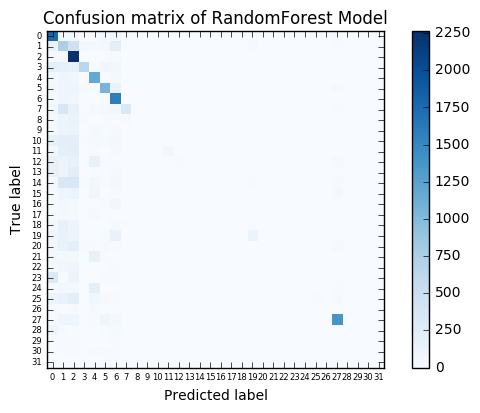

In [86]:
plot_confusion_matrix(confusion_matrix_rf, classes = label_list,normalize = False, title = 'Confusion matrix of RandomForest Model')

In [89]:
Vocab

[u'section',
 u'shall',
 u'state',
 u'act',
 u'secretari',
 u'subsect',
 u'sec',
 u'amend',
 u'unit',
 u'provid',
 u'year',
 u'may',
 u'paragraph',
 u'servic',
 u'titl',
 u'program',
 u'000',
 u'follow',
 u'requir',
 u'author',
 u'includ',
 u'fund',
 u'feder',
 u'amount',
 u'general',
 u'insert',
 u'appropri',
 u'use',
 u'term',
 u'date',
 u'purpos',
 u'plan',
 u'strike',
 u'health',
 u'agenc',
 u'nation',
 u'determin',
 u'individu',
 u'hous',
 u'report',
 u'applic',
 u'congress',
 u'assist',
 u'law',
 u'made',
 u'public',
 u'fiscal',
 u'administr',
 u'relat',
 u'avail',
 u'establish',
 u'offic',
 u'subparagraph',
 u'person',
 u'effect',
 u'inform',
 u'respect',
 u'mean',
 u'develop',
 u'code',
 u'govern',
 u'committe',
 u'activ',
 u'end',
 u'period',
 u'provis',
 u'educ',
 u'describ',
 u'grant',
 u'secur',
 u'new',
 u'enact',
 u'repres',
 u'cost',
 u'appli',
 u'part',
 u'payment',
 u'delet',
 u'project',
 u'regul',
 u'member',
 u'oper',
 u'depart',
 u'carri',
 u'day',
 u'care',
 u'com

In [92]:
with open('Vocab.dat','w') as f:
    f.write('The ordered subjects are: {} \n\n'.format(subject_ordered))
    f.write('The vocabulary(5000) are: {}'.format(Vocab))